In [1]:
# Import required libraries
import cv2
import glob
import imutils # A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, detecting edges
import numpy as np
import easyocr # End-to-End Multi-Lingual Optical Character Recognition (OCR) Solution
import matplotlib.pyplot as plt

In [2]:
# Now read all the images
imdir = 'images/'
ext = ['png', 'jpg', 'jpeg']    # Add image formats here

files = []
# Adding all the extension files
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
files

['images/19947383131_7d4ae608e4_k.jpg',
 'images/Datsun-redi-GO-AMT-20.jpg',
 'images/Mahindra-e2oPlus-Green-Color-Number-Plate.jpg',
 'images/Ford-Fiesta-Active-1009566.jpg',
 'images/98d748609558e28b444430be70050362.jpg']

In [3]:
# Reading all the files
images = [cv2.imread(file) for file in files]

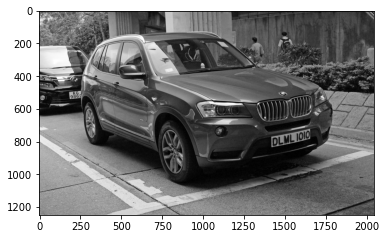

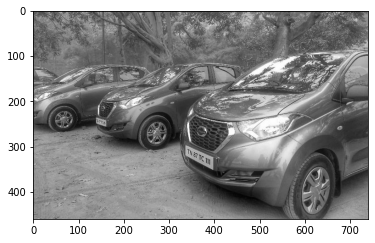

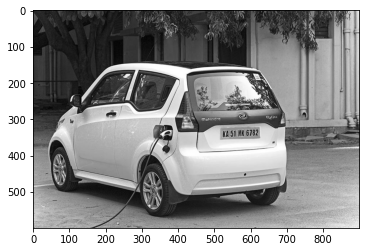

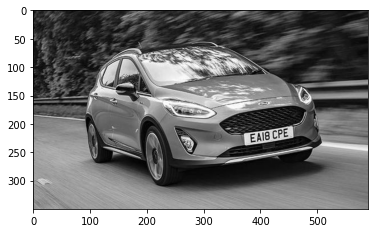

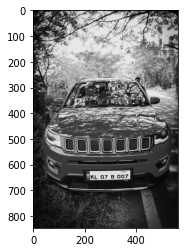

In [4]:
gray_images = []
# Loop is added so we can process all images in a folder
for img in images:
    try:
        # Converting original image to grayscale, cv2 reads in BGR initially and we are converting to Gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Matplotlib expects RGB format, so when displaying any image using it we have to use RGB
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        gray_images.append(gray)
        plt.show() # Add this to print all the images in folder
    except Exception as e:
        print(e)
        print ("{} is not converted".format(img))

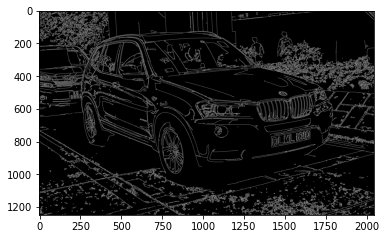

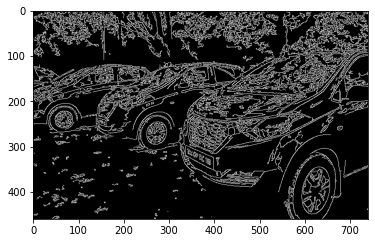

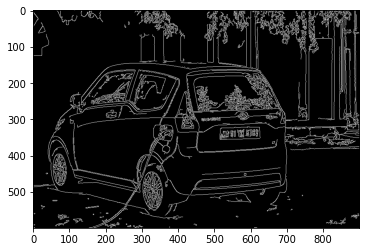

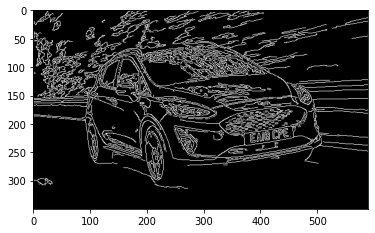

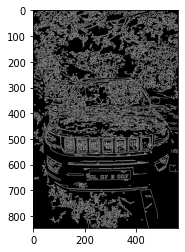

In [5]:
# A bilateral filter is used for smoothening images and reducing noise, while preserving edges.
# The Bilateral Filter operation applies a bilateral image to a filter
#     d: Diameter of each pixel neighborhood.
# sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
# sigmaColor: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.

# Apply bilateral filter with d = 15, 
# sigmaColor = sigmaSpace = 75.

edged_images = []
for img in gray_images:
    try:
        bilateral_img = cv2.bilateralFilter(img, 11, 17, 17) # Noise Reduction
        edged_img = cv2.Canny(bilateral_img, 30, 200) # Edge detection
        plt.imshow(cv2.cvtColor(edged_img, cv2.COLOR_BGR2RGB))
        edged_images.append(edged_img)
        plt.show()
    except Exception as e:
        print(e)
        print ("{} is not converted".format(img))

In [6]:
# Next step is contour detection
# By using contour detection, we can detect the borders of objects, and therefore, localize them easily
# We are finding a rectangle
imgs_contours = []
for img in edged_images:
    try:
        keypoints = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Params: Edged_image, image to be returned as(here we want tree), what type of results(approximate contours)

        # Grabs the appropriate tuple value
        contours = imutils.grab_contours(keypoints)
        # Return top 10 contours
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        imgs_contours.append(contours)
    except Exception as e:
        print(e)
        print ("{} is not converted".format(img))

In [7]:
# Now iterate in these imgs_contours to check if we have got a number plate or some square
numberplate_locations = []
for contour in imgs_contours:
    for c in contour:
        peri = cv2.arcLength(c, True) # arcLength: Calculates contour perimeter or a curve length.
        approx = cv2.approxPolyDP(c, 0.018*peri, True) # second param number should ideally high to get more rough estimation
        # If a rectange is found(polygon with 4 sides)
        if len(approx) == 4:
            location = approx
            numberplate_locations.append(location)
            break

# Approx coordinates of our number plate in images
numberplate_locations

[array([[[1656,  725]],
 
        [[1420,  771]],
 
        [[1420,  834]],
 
        [[1655,  784]]], dtype=int32), array([[[336, 299]],
 
        [[396, 323]],
 
        [[398, 350]],
 
        [[338, 320]]], dtype=int32), array([[[623, 322]],
 
        [[518, 324]],
 
        [[514, 355]],
 
        [[623, 353]]], dtype=int32), array([[[457, 205]],
 
        [[455, 225]],
 
        [[372, 235]],
 
        [[373, 216]]], dtype=int32), array([[[378, 623]],
 
        [[374, 657]],
 
        [[221, 658]],
 
        [[221, 624]]], dtype=int32)]

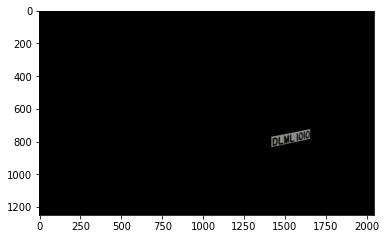

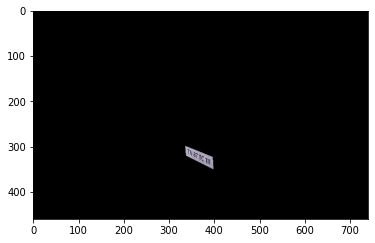

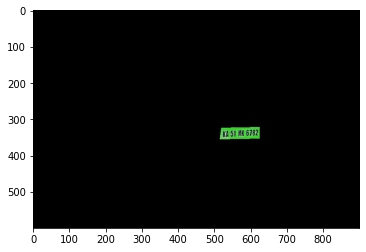

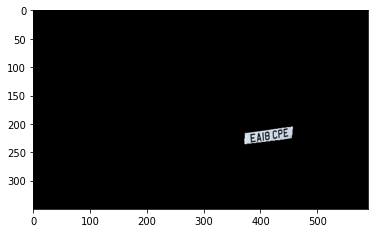

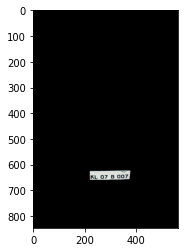

In [8]:
# Now we will do masking
masks = []
for idx, img in enumerate(images):
    try:
        mask = np.zeros(gray_images[idx].shape, np.uint8) # A mask is created of zeros of same shape as orig gray image
        masks.append(mask) # Storing all mask as they will be used afterwards
        new_image = cv2.drawContours(mask, [numberplate_locations[idx]], 0, 255, -1) # draw contours at the specified location
        new_image = cv2.bitwise_and(img, img, mask=mask) # Overlay the mask over original image
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.show()
    except Exception as e:
        print(e)
        print ("{} is not converted".format(img))

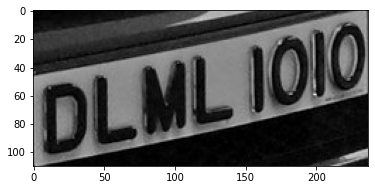

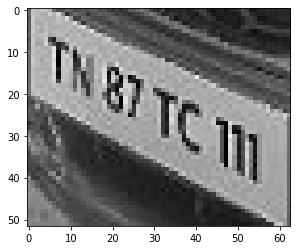

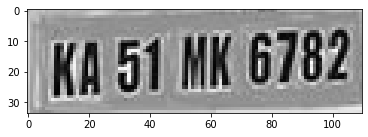

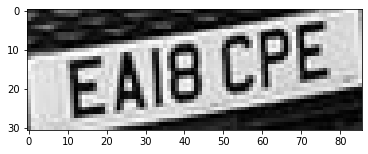

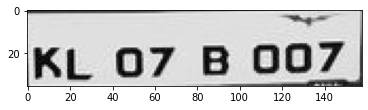

In [9]:
# Now crop the number plate
number_plates = []

for idx, img in enumerate(gray_images):
    (x, y) = np.where(masks[idx]==255) # Store every section where image is not black
    (x_min, y_min) = (np.min(x), np.min(y)) # To get the left top coordinate of (x, y) in numberplate which is not black
    (x_max, y_max) = (np.max(x), np.max(y)) # To get the bottom right coordinate of (x, y) in numberplate which is not black
    cropped_img = img[x_min:x_max+1, y_min:y_max+1] # +1 is done as second term after colon is exclusive
    number_plates.append(cropped_img)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.show()
    

In [10]:
# Now we have to read the text, we will use easyocr library

# Iterating in all cropped number plates
result = []
for img in number_plates:
    reader = easyocr.Reader(["en"]) # Instantiate the reader from easyocr library
    result.append(reader.readtext(img)) # Read text in image and append it to final result


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [11]:
result

[[([[130.67994083773704, 14.343804764532212],
    [239.75636489347568, -8.555561466959093],
    [250.32005916226296, 62.65619523546779],
    [142.24363510652432, 85.55556146695909]],
   'Jo1d',
   0.24642646312713623),
  ([[-8.539496915923952, 39.365710485858564],
    [147.51404254109707, 16.04629788031379],
    [153.53949691592396, 90.63428951414143],
    [-2.5140425410970595, 114.95370211968621]],
   'DLM',
   0.7195206408990986)],
 [([[5.4647122724278105, 1.0729641807401187],
    [50.990074380419976, 22.800992561958],
    [42.53528772757219, 40.927035819259885],
    [-2.990074380419978, 18.199007438042]],
   'T*87TC >',
   0.22507393143581217)],
 [([[4, 2], [110, 2], [110, 32], [4, 32]],
   'Ka 51 MK 6782',
   0.5846138718229161)],
 [([[46, 0], [82, 0], [82, 26], [46, 26]], 'CPE', 0.9873852895508469),
  ([[3.335899411324313, 7.503849116986469],
    [49.46657657493134, 2.292370063509075],
    [51.66410058867569, 27.49615088301353],
    [5.533423425068664, 32.707629936490925]],
   'EA

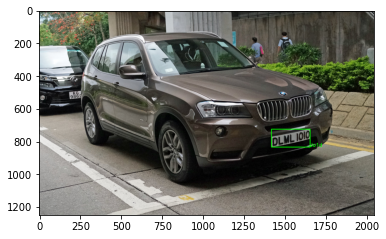

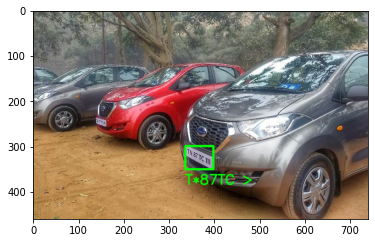

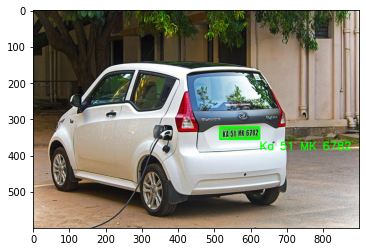

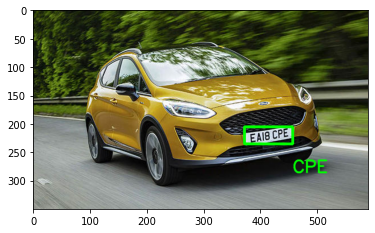

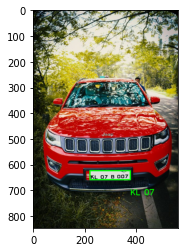

In [16]:
for idx, img in enumerate(images):
    text = result[idx][0][-2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    updated_img = cv2.putText(img, text=text, org=(numberplate_locations[idx][0][0][0], numberplate_locations[idx][1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    updated_img = cv2.rectangle(img, tuple(numberplate_locations[idx][0][0]), tuple(numberplate_locations[idx][2][0]), (0,255,0),3)
    plt.imshow(cv2.cvtColor(updated_img, cv2.COLOR_BGR2RGB))
    plt.show()